**Data Preprocessing & Cleaning**

Primary:
- id (Id of track generated by Spotify)

Numerical:
- acousticness (Ranges from 0 to 1)
    - whether the song is acoustic or not, 0(not acoustic)->1(very acoustic)
- danceability (Ranges from 0 to 1)
    - how suitable the track is for dancing, 0(not danceable)->1(very danceable)
- energy (Ranges from 0 to 1)
    - how energetic the track is, 0(less energetic)->1(very energetic)
- duration_ms (Integer typically ranging from 200k to 300k)
    - Time in MS
- instrumentalness (Ranges from 0 to 1)
    - the ratio of instrumental sounds overall, 0(lot of vocal sounds)->1(instrument sounds)
- valence (Ranges from 0 to 1)
    - how positive the music is, 0(sad)->1(cheerful)
- popularity (Ranges from 0 to 100)
    - popularity of track
- tempo (Float typically ranging from 50 to 150)
    - tempo of track in BPM
- liveness (Ranges from 0 to 1)
    - presence of audience, 0(studio record)->1(concert)
- loudness (Float typically ranging from -60 to 0)
    - how loud the song is in dB -60(very quiet)->0(very loud)
- speechiness (Ranges from 0 to 1)
    - the ratio of spoken words to the overall, 0(instrumental)->1(talk show)

Dummy:
- mode 
    - (0 = Minor, 1 = Major)

Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
    - the major key of the track, 0:C, 1:C#, 2:D, ..., 11:B
        0. Key of C
        1. Key of C#/Db (enharmonic keys)
        2. Key of D
        3. Key of D#/Eb
        4. Key of E
        5. Key of F
        6. Key of F#/Gb (enharmonic keys)
        7. Key of G
        8. Key of G#/Ab
        9. Key of A
        10. Key of A#/Bb
        11. Key of B
- timesignature 
    - (The predicted timesignature, most typically 4)

In [1]:
import numpy as np
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
# import os
# import re

In [2]:
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

# sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=os.environ.get('SPOTIPY_CLIENT_ID'),
#                                                            client_secret=os.environ.get('SPOTIPY_CLIENT_SECRET')))


In [3]:
key_octave_values = ['C', 'C#/Db','D','D#/Eb', 'E',
                    'F', 'F#/Gb', 'G', 'G#/Ab', 'A',
                    'A#/Bb', 'B']

mode_mm_values = ['Minor', 'Major']
explicit_values = ['Clean', 'Explicit']

In [4]:
column_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 
                'track_href', 'analysis_url', 'duration_ms', 'time_signature']

In [5]:
def user_playlist_tracks_full(spotify_connection=sp, user=None, 
                              playlist_id=None, genre=None):

    # first run through also retrieves total no of songs in library
    response = spotify_connection.user_playlist_tracks(user, playlist_id, limit=100)
    results = response["items"]

    # subsequently runs until it hits the user-defined limit or has read all songs in the library
    while len(results) < response["total"]:
        response = spotify_connection.user_playlist_tracks(
            user, playlist_id, limit=100, offset=len(results)
        )
        results.extend(response["items"])
    
    playlist_song_ids = []
    for each in range(len(results)):
        playlist_song_ids.append((results[each]['track']['id']))
    #Remove possible nones
    playlist_song_ids = [i for i in playlist_song_ids if i]
    
    theDataFrame = pd.DataFrame(columns = column_names)
    while(len(playlist_song_ids)>0):
        theDataFrame = theDataFrame.append(sp.audio_features(playlist_song_ids[:100]),ignore_index=True)
        playlist_song_ids = playlist_song_ids[100:]
    
    theDataFrame['genre'] = genre

    return theDataFrame

In [6]:
alt_metal_songs = user_playlist_tracks_full(playlist_id = '40DeXsA9tEIwNwBmrZ4rkt', genre = 'alt-metal')
len(alt_metal_songs)

1285

In [7]:
hiphop_songs = user_playlist_tracks_full(playlist_id = '13u9Bn677jEHePtS7XKmih', genre = 'hip-hop')
len(hiphop_songs)

2189

In [8]:
rock_songs = user_playlist_tracks_full(playlist_id = '1SY54UtMrIadoVThZsJShG', genre = 'rock')
len(rock_songs)

1084

In [9]:
pop_songs = user_playlist_tracks_full(playlist_id = '1szFiylNjSI99tpQgVZ3ki', genre = 'pop')
len(pop_songs)

710

In [10]:
all_songs = hiphop_songs.append([pop_songs, rock_songs, alt_metal_songs], ignore_index=True)

In [11]:
all_songs.drop(['type', 'uri', 'track_href', 'analysis_url'], axis = 1, inplace = True)

In [12]:
all_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5268 non-null   float64
 1   energy            5268 non-null   float64
 2   key               5268 non-null   object 
 3   loudness          5268 non-null   float64
 4   mode              5268 non-null   object 
 5   speechiness       5268 non-null   float64
 6   acousticness      5268 non-null   float64
 7   instrumentalness  5268 non-null   float64
 8   liveness          5268 non-null   float64
 9   valence           5268 non-null   float64
 10  tempo             5268 non-null   float64
 11  id                5268 non-null   object 
 12  duration_ms       5268 non-null   object 
 13  time_signature    5268 non-null   object 
 14  genre             5268 non-null   object 
dtypes: float64(9), object(6)
memory usage: 617.5+ KB


In [13]:
all_songs.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000
mean,0.570284,0.705044,-7.176929,0.145271,0.161369,0.093543,0.244300,0.463618,118.392675
std,0.180104,0.198816,3.371045,0.146549,0.232404,0.226143,0.214532,0.239102,30.073932
min,0.000000,0.000020,-35.553000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000
25%,0.440750,0.583000,-8.707250,0.041600,0.003108,0.000000,0.102000,0.277000,93.980250
50%,0.571000,0.733000,-6.510000,0.078700,0.048450,0.000049,0.154000,0.449000,115.067500
75%,0.711000,0.863000,-4.935000,0.220000,0.228000,0.016350,0.321000,0.647000,139.914000
max,0.966000,0.999000,-0.839000,0.966000,0.996000,0.998000,0.996000,0.989000,214.838000


In [14]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.507,0.985,0,-2.392,1,0.1530,0.22800,0.000033,0.190,0.394,150.059,7hQ0ojbeqicGhw0wdUVeaN,139560,4,hip-hop
1,0.625,0.726,10,-7.731,0,0.1550,0.00728,0.000000,0.318,0.483,103.980,6C7RJEIUDqKkJRZVWdkfkH,311867,4,hip-hop
2,0.552,0.846,9,-4.912,1,0.3420,0.01140,0.000000,0.309,0.554,98.560,2dxjKgT0li4qBI3QwuN9Ih,236600,1,hip-hop
3,0.685,0.631,7,-10.338,1,0.0926,0.02490,0.000077,0.211,0.720,104.126,4oNM6CscdoUZDHvzl18nbt,293493,4,hip-hop
4,0.640,0.864,4,-4.909,0,0.0869,0.04090,0.000002,0.136,0.497,105.107,6XGddj522FQRHXEhBtjiJu,272667,4,hip-hop


In [15]:
all_songs['duration_ms'] = all_songs['duration_ms'].astype(float)

In [16]:
all_songs.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5.268000e+03
mean,0.570284,0.705044,-7.176929,0.145271,0.161369,0.093543,0.244300,0.463618,118.392675,2.410009e+05
std,0.180104,0.198816,3.371045,0.146549,0.232404,0.226143,0.214532,0.239102,30.073932,8.556594e+04
min,0.000000,0.000020,-35.553000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,7.173000e+03
25%,0.440750,0.583000,-8.707250,0.041600,0.003108,0.000000,0.102000,0.277000,93.980250,1.988658e+05
50%,0.571000,0.733000,-6.510000,0.078700,0.048450,0.000049,0.154000,0.449000,115.067500,2.356660e+05
75%,0.711000,0.863000,-4.935000,0.220000,0.228000,0.016350,0.321000,0.647000,139.914000,2.769110e+05
max,0.966000,0.999000,-0.839000,0.966000,0.996000,0.998000,0.996000,0.989000,214.838000,2.238734e+06


In [17]:
all_songs = all_songs.sample(frac=1).reset_index(drop = True)
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.509,0.843,1,-3.318,0,0.0488,0.000671,0.000803,0.3480,0.332,140.055,1gyee1JuFFiP476LQpRMYU,238400.0,3,alt-metal
1,0.644,0.287,2,-14.072,1,0.0257,0.283000,0.005800,0.0705,0.315,103.983,7HgQTacsIKMUiElM725aav,218893.0,4,rock
2,0.478,0.940,0,-3.888,1,0.1250,0.000045,0.002530,0.1310,0.310,164.881,639p4iSG1S0lXJ6RJJ6jLN,196133.0,4,alt-metal
3,0.533,0.320,8,-8.819,1,0.0316,0.731000,0.000017,0.1540,0.291,98.036,64fzn2ewOdSH57wrxTPGov,226160.0,4,pop
4,0.598,0.856,9,-6.204,0,0.3060,0.219000,0.000000,0.2910,0.779,173.929,3ivJymJnoceuUUe7wTP6m4,272627.0,4,hip-hop


In [18]:
all_songs.danceability.nunique()

789

In [19]:
all_songs.energy.nunique()

831

In [20]:
print(f'Number of unique: {all_songs.key.nunique()}')
print(f'All Value Counts:\n{all_songs.key.value_counts()}')

Number of unique: 12
All Value Counts:
1     683
7     552
2     532
9     510
0     482
11    441
6     409
4     403
10    387
8     374
5     374
3     121
Name: key, dtype: int64


In [21]:
all_songs.loudness.nunique()

3958

In [22]:
all_songs['mode'].value_counts()

1    3223
0    2045
Name: mode, dtype: int64

In [23]:
def plotbar_groupby_genre(groupby, genre, feature, ax, ticklabel = None, orient='h'):

    if (orient=='h'):
            if(ticklabel is None):
                ax.barh(groupby.index.sort_values(ascending=False),
                       groupby.values)
            else:
                   ax.barh(groupby.index.sort_values(ascending=False),
                   groupby.values,
                   tick_label = ticklabel)
    else:
            if(ticklabel is None):
                ax.bar(groupby.index.sort_values(ascending=False),
                       groupby.values)
            else:
                ax.bar(groupby.index.sort_values(ascending=False),
                groupby.values,
                tick_label = ticklabel)
    ax.set_title(f'# Songs in {feature} within {genre} ', fontdict = {'fontsize' : 15})
    ax.set_ylabel('Count', fontdict = {'fontsize' : 12})

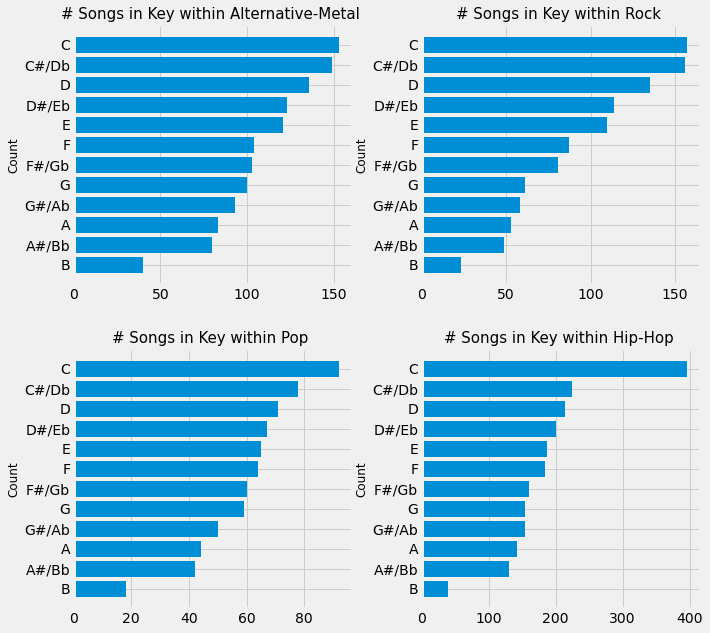

In [24]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
fig.subplots_adjust(hspace=.25, wspace = .25)
am_group_key = all_songs.groupby('genre').key.value_counts()['alt-metal']
vc_keys_hh = all_songs.groupby('genre').key.value_counts()['hip-hop']
vc_keys_pop = all_songs.groupby('genre').key.value_counts()['pop']
vc_keys_rock = all_songs.groupby('genre').key.value_counts()['rock']

plotbar_groupby_genre(am_group_key, 'Alternative-Metal', 'Key', 
                   axes[0,0], ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_rock, 'Rock','Key',
                   axes[0,1],  ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_pop, 'Pop','Key', 
                   axes[1,0], ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_hh, 'Hip-Hop', 'Key',
                   axes[1,1], ticklabel = key_octave_values)

plt.show()

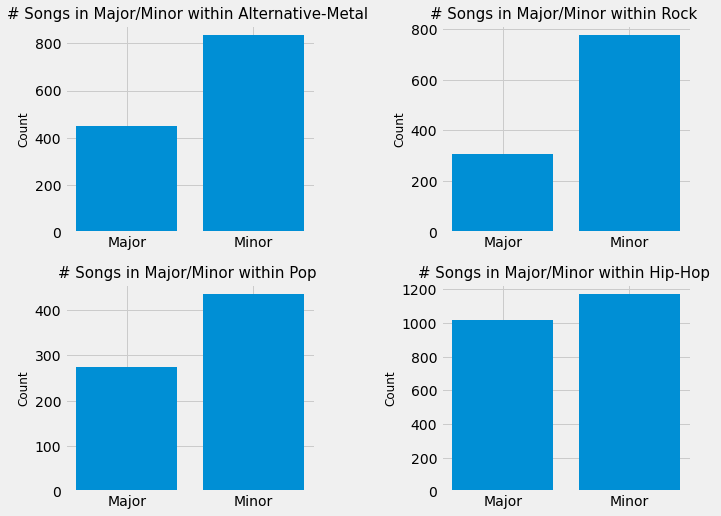

In [25]:
fig, axes = plt.subplots(2,2, figsize = (10,8))
fig.subplots_adjust(hspace=.25, wspace = .50)
vc_mode_am = all_songs.groupby('genre')['mode'].value_counts()['alt-metal']
vc_mode_rock = all_songs.groupby('genre')['mode'].value_counts()['rock']
vc_mode_pop = all_songs.groupby('genre')['mode'].value_counts()['pop']
vc_mode_hh = all_songs.groupby('genre')['mode'].value_counts()['hip-hop']

plotbar_groupby_genre(vc_mode_am, 'Alternative-Metal', 'Major/Minor', 
                   axes[0,0], ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_rock, 'Rock','Major/Minor',
                   axes[0,1],  ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_pop, 'Pop','Major/Minor', 
                   axes[1,0], ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_hh, 'Hip-Hop', 'Major/Minor',
                   axes[1,1], ticklabel = mode_mm_values, orient='v')

In [26]:
def mean_by_genre_plot(groupby, feature):
    fig, ax = plt.subplots()
    sns.barplot(x = all_songs.groupby('genre')[feature].mean().index,
                y = all_songs.groupby('genre')[feature].mean().values,
                ax = ax,)
    ax.set_title(f'{feature.title()} by Genre')
    ax.set_ylabel(f'{feature}');
    plt.xticks(rotation=90)

    plt.show()

In [27]:
genre_group = all_songs.groupby('genre')

In [28]:
continuous_features = list(all_songs.select_dtypes(include = [float, int]).columns)

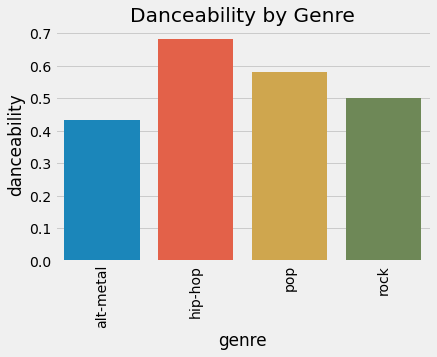

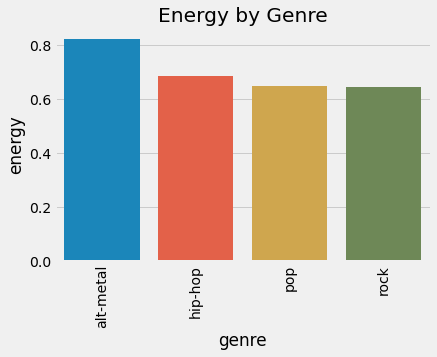

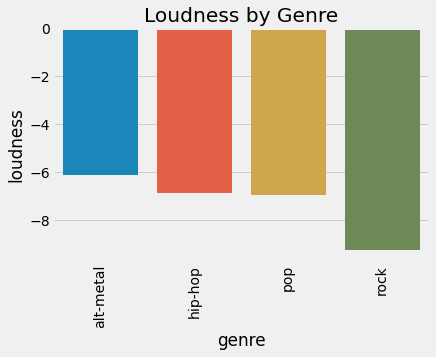

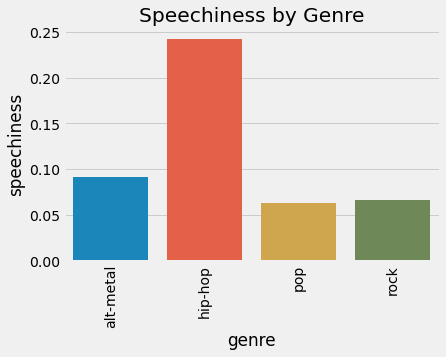

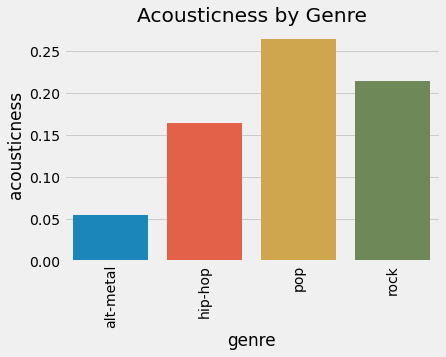

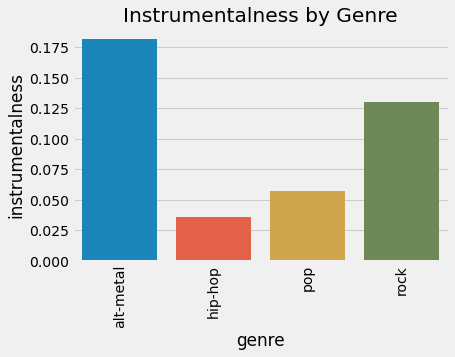

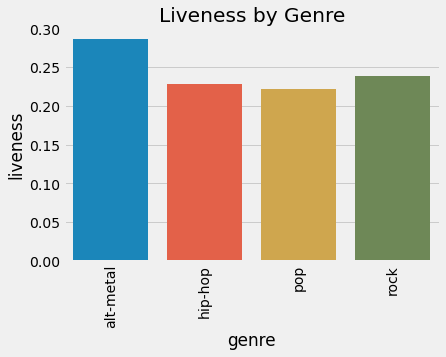

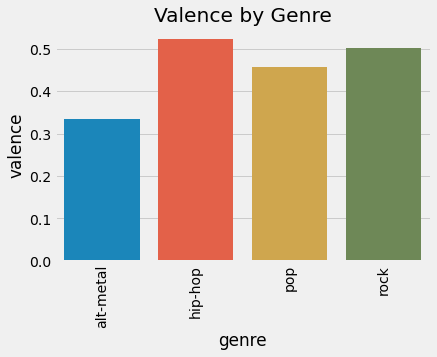

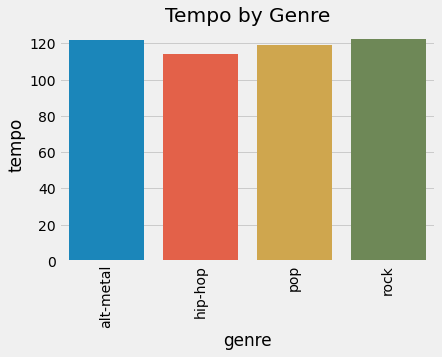

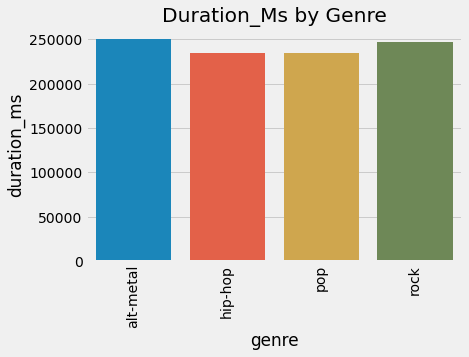

In [29]:
for each in continuous_features:
    mean_by_genre_plot(genre_group, each)

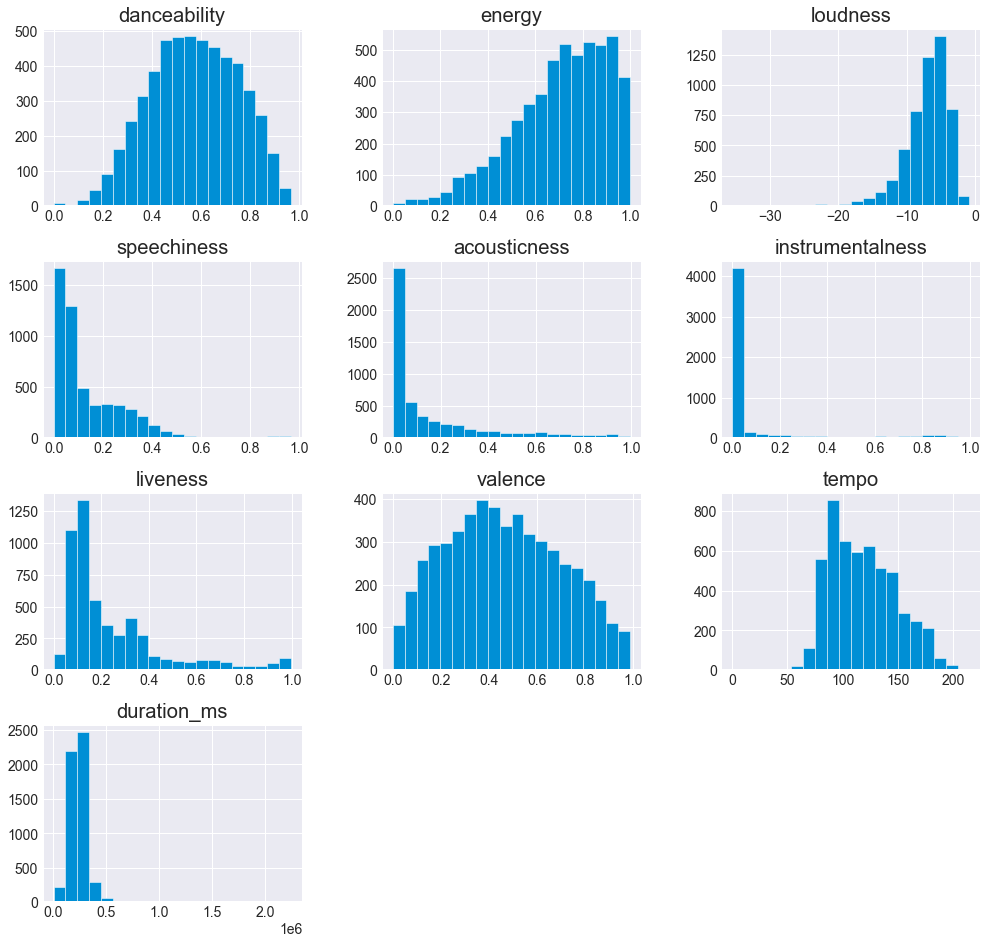

In [43]:
all_songs.hist(bins=20, figsize=(15,15));

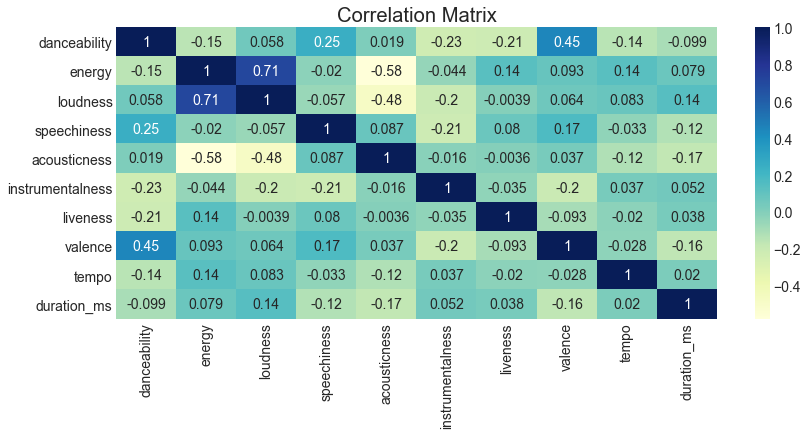

In [112]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(all_songs.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

In [2]:
import pickle

In [3]:
#Export the model to be used in the other notebooks.
# pickle_out = open('pickled_files/df.pickle',"wb")
# pickle.dump(all_songs, pickle_out)
# pickle_out.close()